In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
from matplotlib import cm
from matplotlib import colors as c
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

In [175]:
class plotter():
    def __init__(self,walkers,data_dir, igal):
        self.num_walkers = walkers
        self.igal = igal
        self.data_dir = data_dir
        self.f = h5py.File(self.data_dir,'r')
        self.mcmc_data = None
        specs,meta = Data.Spectra(sim='lgal',noise = 'none', lib = 'bc03', sample = 'mini_mocha')
        photo, _ = Data.Photometry(sim='lgal', noise= 'none', lib='bc03', sample = 'mini_mocha') 
        self.meta_data = meta
        self.prior = self.f['prior_range']
        
        
    def plot_raw(self,param_idx,all_data = False):
        keys = list(self.f.keys())
        # Get the number of mcmc_chain columns
        num = -1
        for k in keys:
            if 'mcmc_chain' in k:
                num += 1
        
        # If all_data == False, take the last mcmc_chain column
        if not all_data:
            self.mcmc_data = self.f[f'mcmc_chain{num}'][...][:,:,param_idx]

        # Otherwise, take all 
        else:
            self.mcmc_data = np.array([])
            for idx in range(num+1):
                self.mcmc_data = np.append(self.mcmc_data,self.f[f'mcmc_chain{idx}'][...][:,:,param_idx])
        
        fig, ax = plt.subplots(1,1,figsize = (10,10))
        length = len(self.mcmc_data)//self.num_walkers
        for i in range(self.num_walkers):
            plt.plot(np.arange(length),self.mcmc_data[i::self.num_walkers], c = 'steelblue', lw = 0.5)
        plt.ylim(self.prior[param_idx])
        label = np.array(self.f['theta_names'][...]).astype(str)[param_idx]
        plt.ylabel(f'Prior Range\n{label})')
        plt.title(f'igal{self.igal} Walker Distribution {label}')
        plt.xlabel('Iteration')
        
    def plot_total_median(self,param_idx, inc = 1000, thin = 0):
        keys = list(self.f.keys())
        
        num = -1
        for k in keys:
            if 'mcmc_chain' in k:
                num += 1
                
        self.mcmc_data = np.array([])
        for idx in range(num+1):
            self.mcmc_data = np.append(self.mcmc_data,self.f[f'mcmc_chain{idx}'][...][:,:,param_idx])
        
        walker_mcmc = []
        for i in range(self.num_walkers):
            walker_mcmc.append(self.mcmc_data[i::self.num_walkers])
            
        
        for i, walker in enumerate(walker_mcmc):
            running_median = []
            walker = walker[::thin]
            length = len(walker)
            for ii in range(length//inc):
                running_median.append(np.median(walker[:(ii+1)*inc:thin]))
            
            walker_mcmc[i] = running_median
        
        
        total_med = np.median(walker_mcmc,axis = 0)
        fig, ax = plt.subplots(1,1,figsize = (10,10))
        plt.plot(np.arange(len(total_med))*inc*self.num_walkers, total_med, c = 'steelblue', lw = 0.5)
        plt.ylim(self.prior[param_idx])
        label = np.array(self.f['theta_names'][...]).astype(str)[param_idx]
        plt.ylabel(f'Prior Range\n{label})')
        plt.title(f'igal{self.igal} Median {label}')
        plt.xlabel('Iteration')
        
    def plot_walker_median(self,param_idx,inc = 1000, thin = 0):
        keys = list(self.f.keys())
        
        num = -1
        for k in keys:
            if 'mcmc_chain' in k:
                num += 1
                
        self.mcmc_data = np.array([])
        for idx in range(num+1):
            self.mcmc_data = np.append(self.mcmc_data,self.f[f'mcmc_chain{idx}'][...][:,:,param_idx])
        
        walker_mcmc = []
        for i in range(self.num_walkers):
            walker_mcmc.append(self.mcmc_data[i::self.num_walkers])
            
        
        for i, walker in enumerate(walker_mcmc):
            running_median = []
            walker = walker[::thin]
            length = len(walker)
            for ii in range(length//inc):
                running_median.append(np.median(walker[:(ii+1)*inc:thin]))
            
            walker_mcmc[i] = running_median
        
        
        fig, ax = plt.subplots(1,1,figsize = (10,10))
        for walker in walker_mcmc:
            ax.plot(np.arange(len(walker))*inc, walker, c = 'steelblue', lw = 0.5)
        plt.ylim(self.prior[param_idx])
        label = np.array(self.f['theta_names'][...]).astype(str)[param_idx]
        plt.ylabel(f'Prior Range\n{label})')
        plt.title(f'igal{self.igal} Walker Median {label}')
        plt.xlabel('Iteration')
            
    def report_median(self,param_idx,all_data = False):
        keys = list(self.f.keys())
        print(self.f['theta_names'][...])
        
        num = -1
        for k in keys:
            if 'mcmc_chain' in k:
                num += 1
        if not all_data:
            self.mcmc_data = self.f[f'mcmc_chain{num}'][...][:,:,param_idx]
        else:
            self.mcmc_data = np.array([])
            for idx in range(num+1):
                self.mcmc_data = np.append(self.mcmc_data,self.f[f'mcmc_chain{idx}'][...][:,:,param_idx])
        med = np.median(self.mcmc_data)
        
        print(med)
        return med

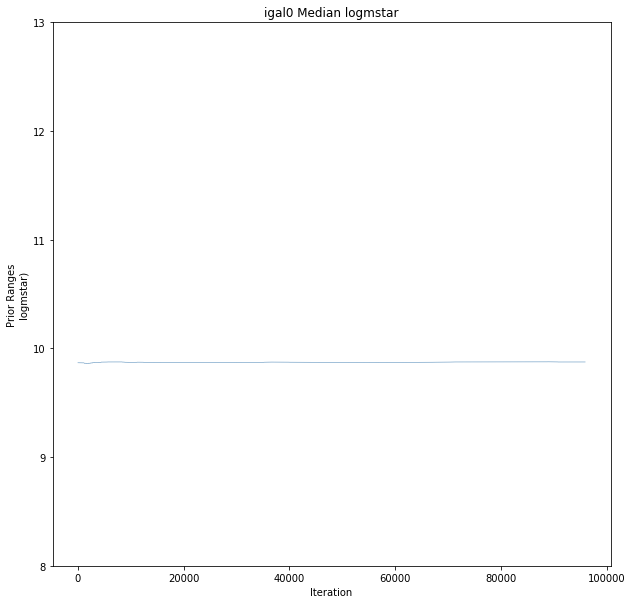

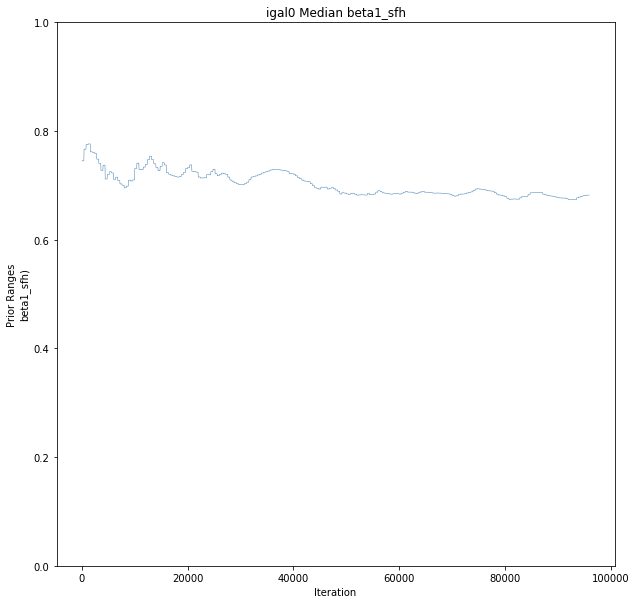

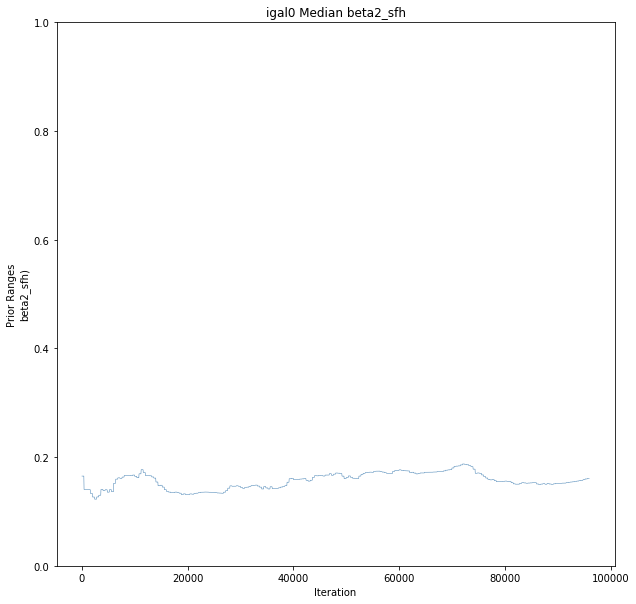

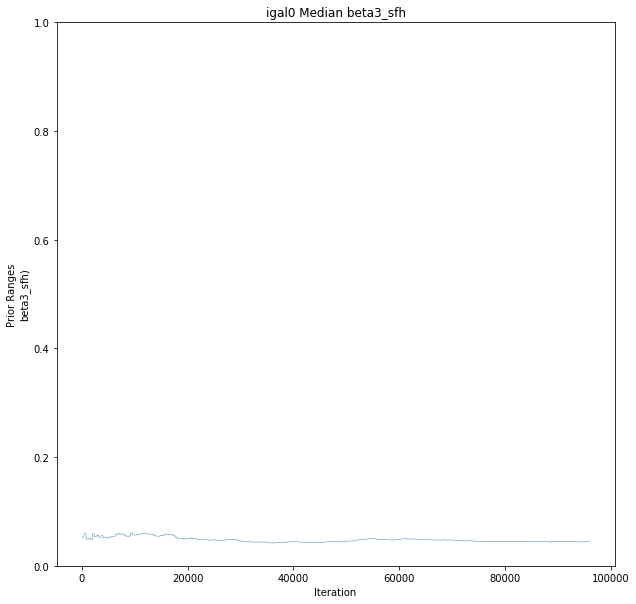

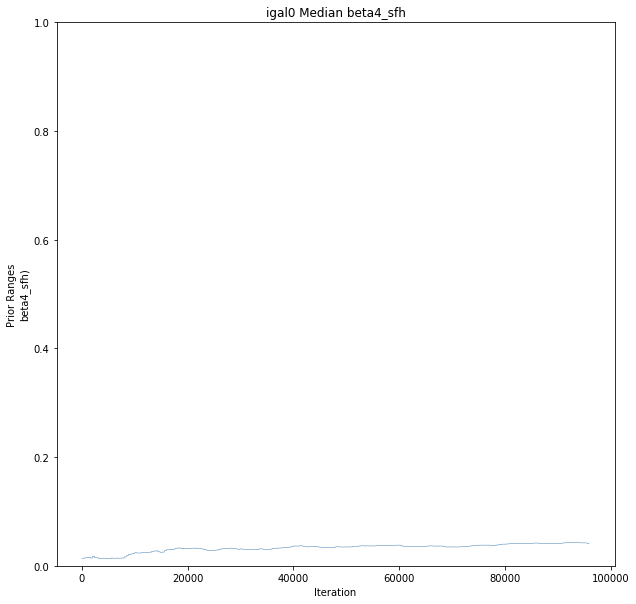

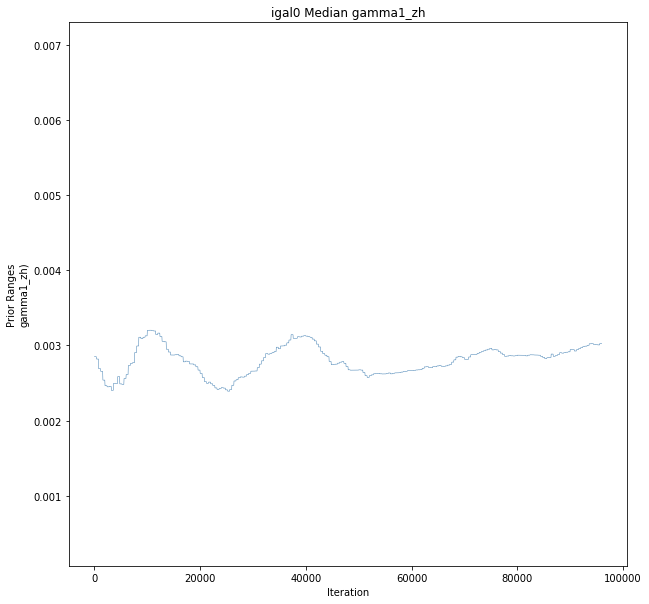

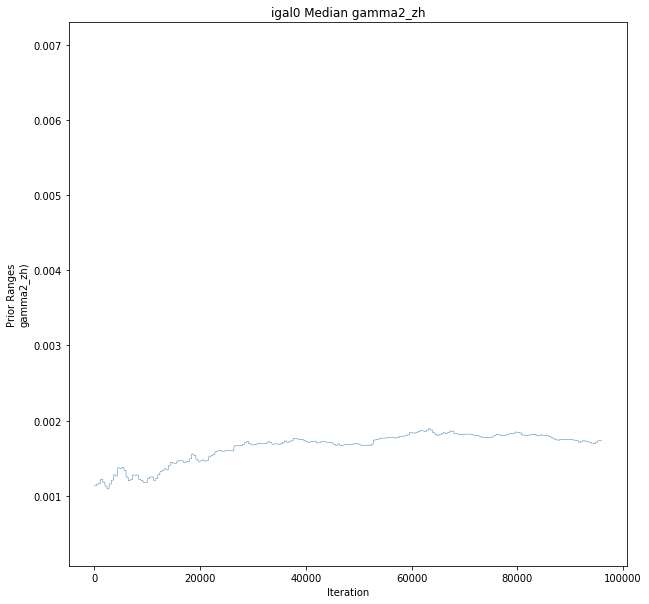

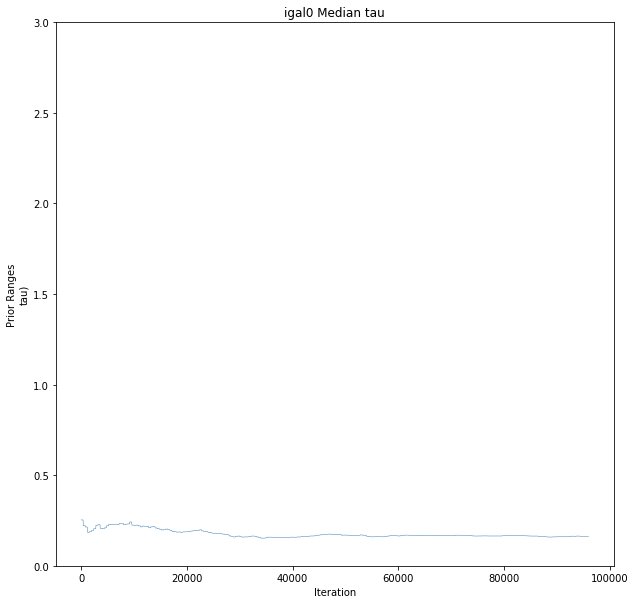

In [174]:
for i in range(97):
    for param_idx in range(8):
        obj = plotter(40,f'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ispeculator/james/lgal.photo.noise_legacy.emulator.{i}.mcmc.hdf5',i)
        obj.plot_total_median(param_idx, True,10)
#         obj.plot_walker_median(param_idx,thin = 1)
#         obj.plot_raw(param_idx)
    #     obj.report_median(0,True)
    #     plt.show()
    if i == 0:
        break
    